In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry

# Define environment

In [6]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_env(mu=0, sigma=6, quantization=4, cost=1.00, seed=None, branching=[3,1,2], **kwargs):
    if seed is not None:
        np.random.seed(seed)

    def reward(depth):
        if depth > 0:
            return Categorical([-10, -5, 5, 10])
#             d = Normal(mu, sigma).to_discrete(quantization)
#             return Categorical(map(round, d.vals), d.probs)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

env = make_env()

# Optimal policy

Because we can compute the true optimal Q function, we can implement the optimal policy
as a `SoftmaxPolicy` using `Q` as a preference function, and a very low temperature.

In [4]:
from exact import solve
from toolz import compose
h = compose(hash, str)

def maybe(f):
    try:
        return f()
    except IndexError:
        return 0

def hash_x12(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + s[2] +
        h(s[3]) +
        h(s[4])
      ) + maybe(lambda:
      h(s[5] + s[6] +
        h(s[7]) +
        h(s[8])
      ) + maybe(lambda:
      h(s[9] + s[10] +
        h(s[11]) +
        h(s[12])
      ) + maybe(lambda:
      h(s[13] + s[14] +
        h(s[15]) +
        h(s[16])
      ))))
    )

from policies import SoftmaxPolicy

def get_optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state=hash_x12)
    print(V(env.init))  # ~ 5 minutes for 312
    return SoftmaxPolicy(Q)
    
optimal_policy = get_optimal_policy(env)
Q = optimal_policy.preference

8.879117548465729


## Simulate rollouts

Running rollouts of the optimal policy on 200 randomly selected environments.

In [7]:
from agents import run_episode
def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env_id, env in envs.items():
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r}

envs = Series([make_env() for _ in range(200)])
df_optimal = DataFrame(simulate(optimal_policy, envs))

## View rollouts

In [ ]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)

# Model

`SoftMaxPolicy` selects actions by sampling from action probabilities generated by its
`action_distribution` method. We can use that method as a likelihood model as well.
I print summary statistics to get an idea of the fit quality. "Predictive power" (a name I made up)
is very similar to _perplexity_, but it's in probability units.

In [9]:
def policy_model(policy, data):
    return data.apply(lambda row: policy.action_distribution(row.state)[row.action], axis = 1)

logp_optimal = np.log(policy_model(optimal_policy, df_optimal))
print('Probabilities of optimal policy actions under the optimal model')
print(np.exp(logp_optimal).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_optimal.mean()):.3f}', )

Probabilities of optimal policy actions under the optimal model
0.166667    201
0.200000      1
0.250000    153
0.333333     10
0.500000    409
1.000000    531
dtype: int64

Predictive power: 0.514


## Load Human Data

In [198]:
from analysis_utils import *
VERSION = 'c0.7'
data = get_data(VERSION, '../experiment/data')
pdf = data['participants']
print(f'{len(pdf)} participants')
mdf = data['mouselab-mdp']
mdf['clicks'] = mdf.queries.apply(extract)
mdf['n_clicks'] = mdf.clicks.apply(len)
mdf['thinking'] = mdf['rt'].apply(get(0))

tdf = mdf.query('block == "test"').copy()
tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.mean()
pdf['thinking'] = mdf.groupby('pid').thinking.mean()

20 participants


In [199]:
def get_env(state_rewards):
    state_rewards[0] = 0
    return make_env(ground_truth=state_rewards)
tdf['env'] = tdf.state_rewards.apply(get_env)

In [200]:
TRIALS = pd.read_json('../experiment/experiment/static/json/rewards/312.json')
TRIALS = TRIALS.drop_duplicates(subset='trial_id').set_index('trial_id').stateRewards

assert len(tdf.pid.unique()) == tdf.pid.max() + 1
def expand(df):
    for i, row in df.iterrows():
        env = row.env
        for a in [*row.clicks, env.term_action]:
            yield {'pid': row.pid, 'trial_id': row.trial_id,
                   'state': env._state, 'action': a}
            env.step(a)

data = pd.DataFrame(expand(tdf))
print(f'{len(data)} observations)')
data.head()

1060 observations)


,action,pid,state,trial_id
0,1,0,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",8130696467842232320
1,13,0,"(0, -5, ((-10, 0.25), (-5, 0.25), (5, 0.25), (...",8130696467842232320
2,13,0,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",-7611027172769307648
3,5,0,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",8491606456270313472
4,13,0,"(0, ((-10, 0.25), (-5, 0.25), (5, 0.25), (10, ...",8491606456270313472


## Grid Search on temperature and error probability

In [218]:
np.arange(10)[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

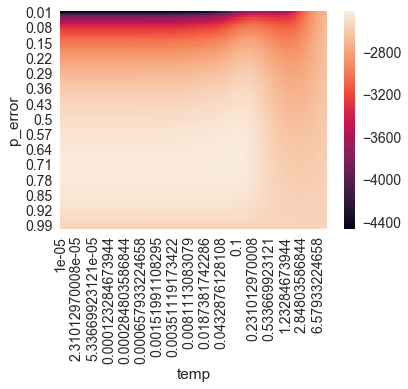

In [220]:
from mouselab_policy import MouselabPolicy
rand_policy = MouselabPolicy({'term_reward': 0})
# NOTE: must run one episode before calling for action_distribution
run_episode(rand_policy, env)

def logp_grid(data):
    prefs = np.stack(data.state.apply(optimal_policy.preferences))
    prefs -= prefs.max(1).reshape(-1, 1)  # prevent float overflow 
    idx = np.arange(len(data))
    chosen = (idx, data.action.as_matrix())
    p_rand = np.stack(data.state.apply(rand_policy.action_distribution))[chosen]

    def logp(temp, p_error):
        eq = np.exp(prefs / temp)
        p_model = eq[chosen] / eq.sum(1)
        return np.log(p_error * p_rand + (1-p_error) * p_model)
               
    def items():
        for t in np.logspace(-5,1, 100):
            for pe in np.linspace(0.01,1, 100):
                yield {'temp': t, 'p_error': pe, 'logp': logp(t, pe).sum()}

    return (DataFrame(items()) 
            .set_index(['p_error', 'temp']) 
            .logp.unstack())

sns.heatmap(logp_grid(data))

In [202]:
from scipy.optimize import minimize

def mle(data):
    logp = logp_grid(data).stack()
    p_error, temp = logp.idxmax()
    best = logp[p_error, temp]
    baseline = logp.iloc[-1]  # p_error = 1
    return {'temp': temp, 
            'p_error': p_error,
            'log_likelihood': best,
            'baseline': baseline,
            'LLR':best - baseline,
            'score': (best - baseline) / len(data)
           }

MLE = DataFrame(list(data.groupby('pid').apply(mle)))
pdf['model_score'] = MLE.score
pdf['LLR'] = MLE.LLR

In [203]:
pdf['bad'] = mdf.query('block == "train_inspector"').groupby('pid').n_clicks.mean() == 0

In [205]:
MLE['temp p_error LLR'.split()].loc[~pdf.bad]

,temp,p_error,LLR
0,0.000010,1.00,0.000000
2,0.100000,0.70,3.127454
3,0.000010,0.76,1.800717
4,0.000010,1.00,0.000000
6,0.200923,0.41,36.550508
7,0.132194,0.24,43.015074
8,0.132194,0.30,34.177643
10,0.000010,1.00,0.000000
12,0.037649,0.68,7.684195
14,0.000010,0.93,0.118647


## Individual differences

In [ ]:
tdf['trial_time'] = tdf.rt.apply(sum) / 1000 / 60 / 60
tdf['bonus'] = tdf['score'] * 0.01
tdf['value'] = tdf.bonus - 7 * tdf.trial_time

pdf['pay'] = (1 + pdf['bonus'].clip(0))
pdf['wage'] = 60 * pdf.pay / pdf.total_time

sns.pairplot(pdf[['n_clicks', 'score', 'wage']], kind='reg')

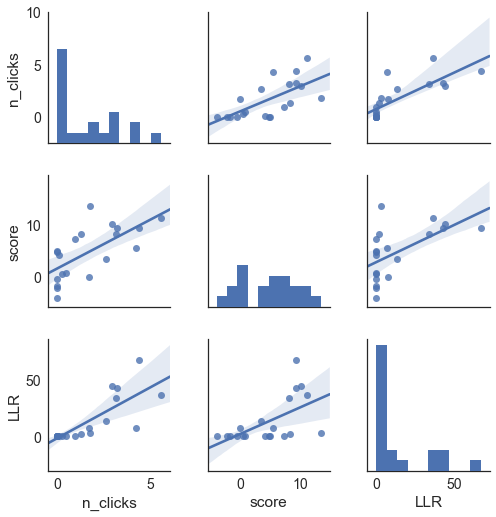

In [210]:
sns.pairplot(pdf[['n_clicks', 'score', 'LLR']], kind='reg')

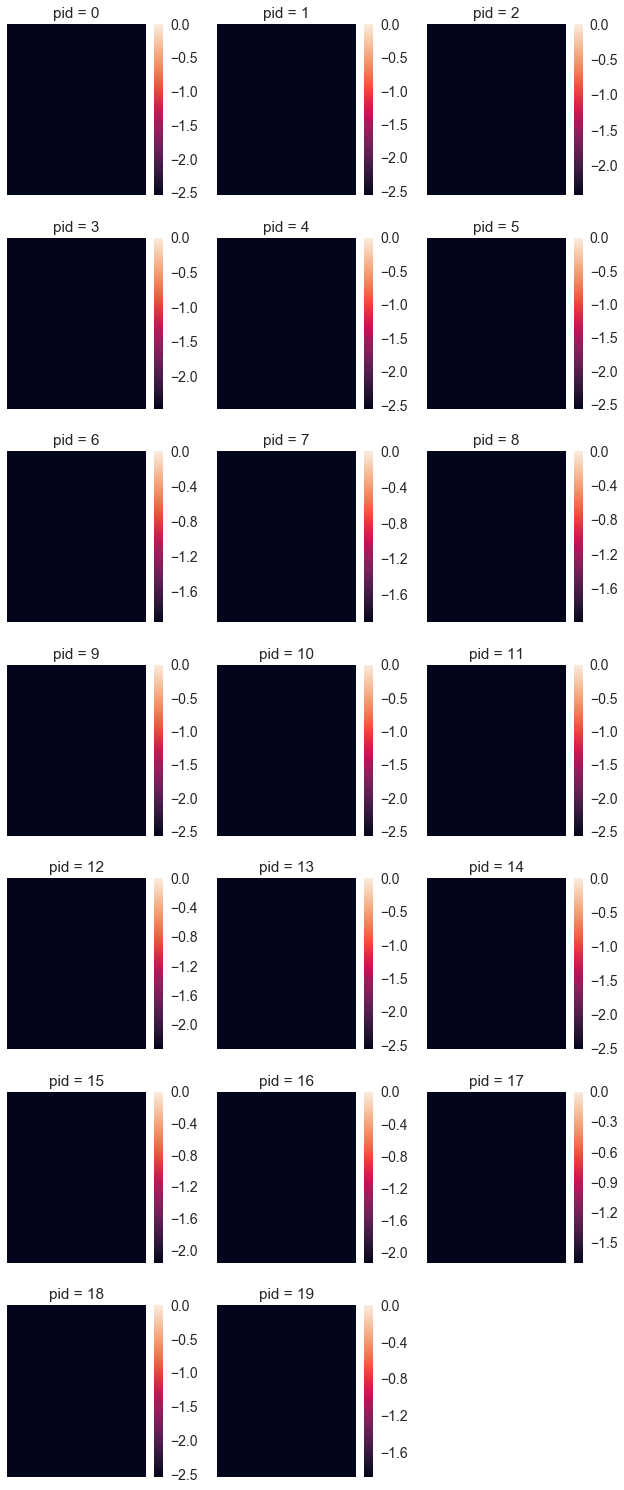

In [211]:
def plotter(data, **kwargs):
    pid = data.pid.iloc[0]
    sns.heatmap(logp_grid(data) / len(data).invert_xaxis()
    plt.xticks([])
    plt.yticks([])
    plt.title(f'score = {MLE.score[pid]}')
    

g = sns.FacetGrid(data, col='pid', col_wrap=3)
g.map_dataframe(plotter)